<a href="https://colab.research.google.com/github/hahaSam351/Study/blob/main/04_House_Prices(stacking)_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices - Advanced Regression Techniques

- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation
- 파이썬 머신러닝 완벽 가이드
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

# 1) Load and check data

## 1-1) Library

In [1]:
# 1.기본
# data handling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# visualization
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우 폰트
# plt.rcParams['font.family'] = 'AppleGothic'   # 애플 폰트
plt.rcParams['font.size'] = 14   # 폰트 크기
plt.rcParams['figure.figsize'] = 8, 8   # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep', font_scale=1.5)

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

# 2. 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')


# 3. 데이터 전처리
# 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 => 원본 데이터 그대로 유지
from sklearn.preprocessing import StandardScaler # SVM(RBF), 로지스틱회귀, 선형회귀, 인공신경망의 경우 표준화(standardization)
from sklearn.preprocessing import MinMaxScaler # 군집 분석의 경우 정규화(normalization)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures # 다항 회귀
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
import missingno as msno
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold


# 5. 분류 모델 구축
# reg (Regression)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Voting
from sklearn.ensemble import VotingRegressor
# Bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
# Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
# Stacking
from sklearn.ensemble import StackingRegressor


# 6. 모델 검정
from sklearn.model_selection import cross_val_score # 검증 지표를 하나만 사용할 경우
from sklearn.model_selection import cross_validate # 검증 지표를 다수를 설정할 경우
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 7. 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1-2) Load and Data Check

In [2]:
train = pd.read_csv(r'/content/drive/MyDrive/DataAnalysis/0. Datasets/house_prices/house_train.csv')
test = pd.read_csv(r'/content/drive/MyDrive/DataAnalysis/0. Datasets/house_prices/house_test.csv')

In [3]:
Idtest = test['Id']
train.drop(columns=['Id'], axis=1, inplace=True)
test.drop(columns=['Id'], axis=1, inplace=True)

In [4]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [5]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print('dataset.shape :', dataset.shape)

train.shape : (1460, 80)
test.shape : (1459, 79)
dataset.shape : (2919, 80)


In [6]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [9]:
dataset.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [10]:
dataset.describe(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,2919,2919,2919,2919,2919,2918,2918,2895,2919,2919,2919,2838,2837,2837,2840,2839,2919,2919,2919,2918,2918,2917,1499,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,2310,2876,1025,1014,1742,1798,2538,1308,1283,2606,1904,851,2493,2874,1493,2723,2671,1492,2717,744,1723,1230,2604,2654,2641,4,329,95,2525,2402


In [11]:
dataset.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

# 2) EDA

## 2-1) Target

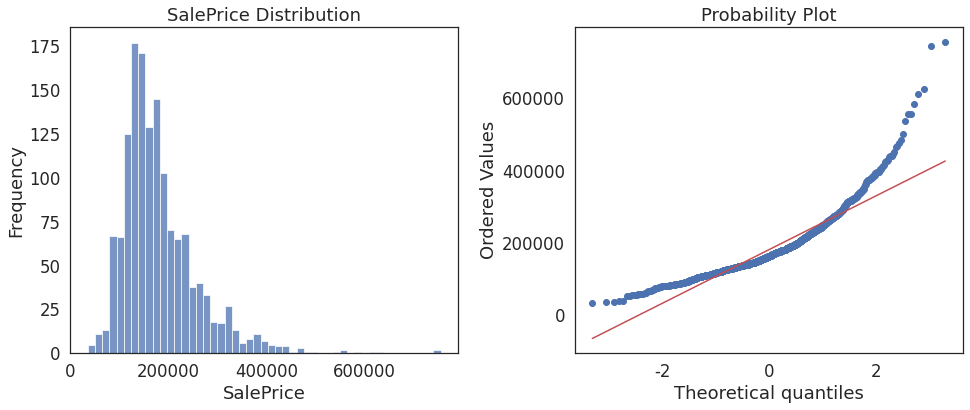

In [12]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
f.subplots_adjust(wspace=0.3)

sns.histplot(train['SalePrice'], ax=ax[0])
ax[0].set_title('SalePrice Distribution')
ax[0].set_ylabel('Frequency')
# ax[0].set_xticklabels(list(range(0,200000, 20000)), rotation=45)

qq = stats.probplot(np.array(train['SalePrice']), plot=ax[1])
plt.show()

- log transformation <br>
 log(0)을 방지하고자 log1P()

 cf. Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

In [13]:
dataset['log_SalePrice'] = np.log1p(dataset['SalePrice'])

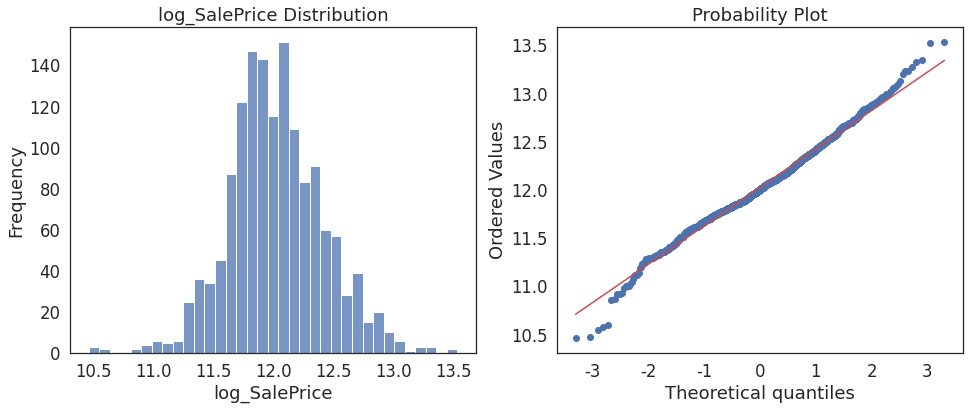

In [14]:
train['log_SalePrice'] = np.log1p(train['SalePrice'])

f, ax = plt.subplots(1, 2, figsize=(16,6))

sns.histplot(train['log_SalePrice'], ax=ax[0])
ax[0].set_title('log_SalePrice Distribution')
ax[0].set_ylabel('Frequency')
# ax[0].set_xticklabels(list(range(0,200000, 20000)), rotation=45)

qq = stats.probplot(np.array(train['log_SalePrice']), plot=ax[1])
plt.show()

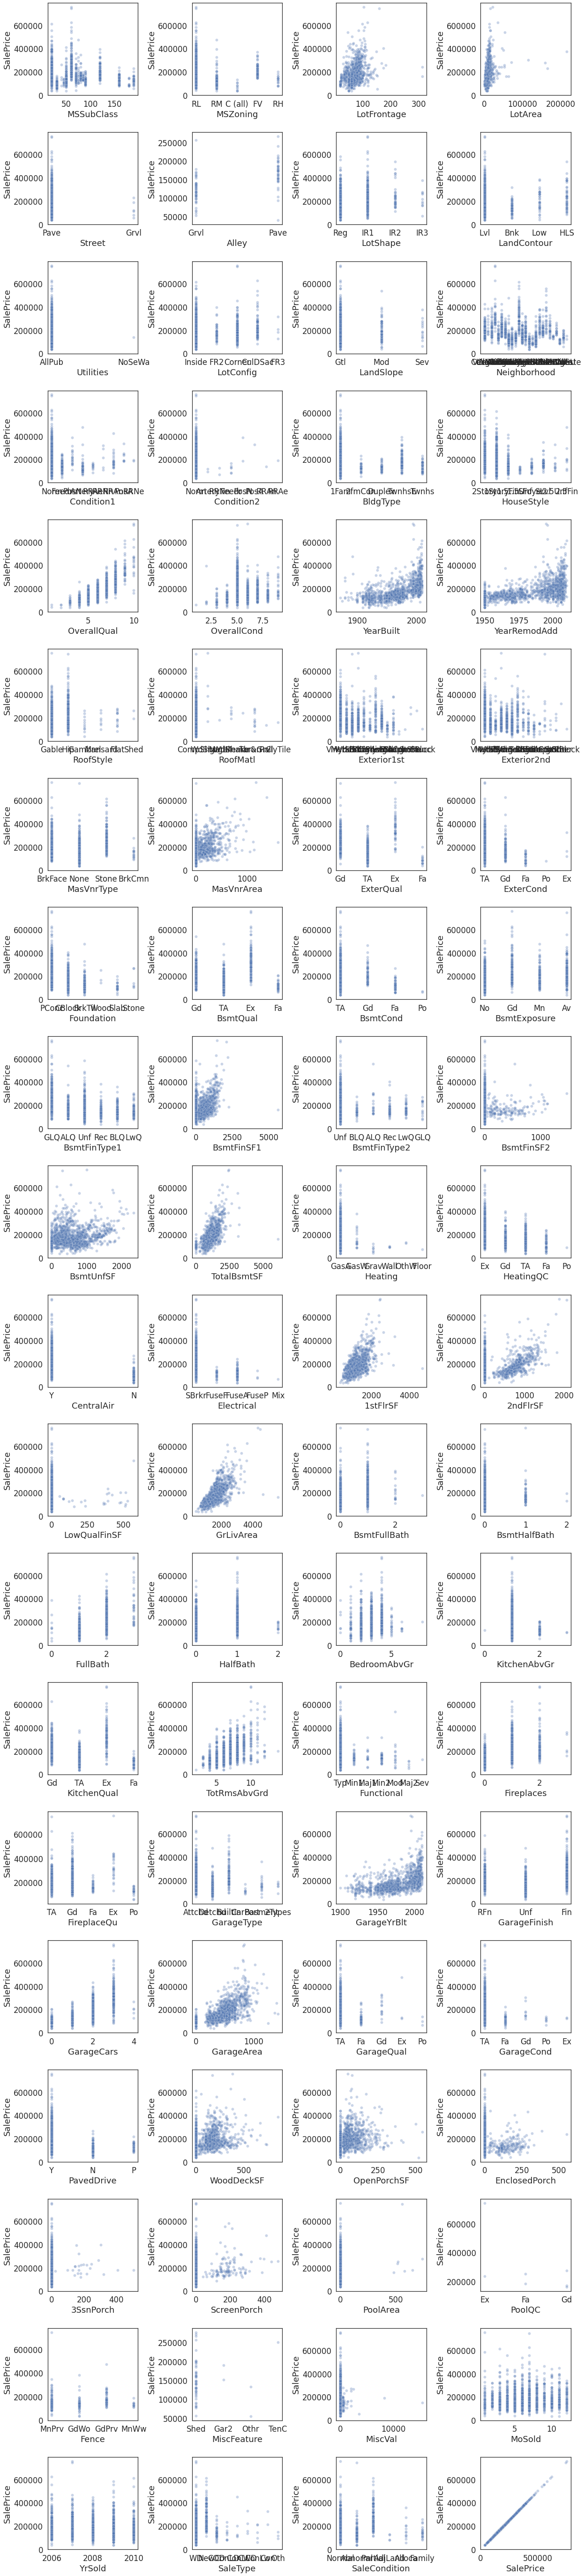

In [15]:
f, ax = plt.subplots(20,4, figsize=(20,100))
f.subplots_adjust(hspace=0.4, wspace=0.6)
for i, feature in enumerate(train.columns[:-1]) :
  row = int(i/4)
  col = i%4
  sns.scatterplot(x=feature, y='SalePrice', data=train, ax=ax[row][col], alpha=0.3)

## 2-2) Features

In [16]:
nan = dataset.isna().sum()[dataset.isna().sum()>0].sort_values(ascending=False)
nan

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
log_SalePrice    1459
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageYrBlt       159
GarageFinish      159
GarageQual        159
GarageCond        159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
Utilities           2
BsmtFullBath        2
KitchenQual         1
Electrical          1
TotalBsmtSF         1
GarageCars          1
GarageArea          1
BsmtUnfSF           1
BsmtFinSF2          1
BsmtFinSF1          1
Exterior2nd         1
Exterior1st         1
SaleType            1
dtype: int64

In [17]:
dataset.dtypes[nan.index]

PoolQC            object
MiscFeature       object
Alley             object
Fence             object
log_SalePrice    float64
SalePrice        float64
FireplaceQu       object
LotFrontage      float64
GarageYrBlt      float64
GarageFinish      object
GarageQual        object
GarageCond        object
GarageType        object
BsmtCond          object
BsmtExposure      object
BsmtQual          object
BsmtFinType2      object
BsmtFinType1      object
MasVnrType        object
MasVnrArea       float64
MSZoning          object
Functional        object
BsmtHalfBath     float64
Utilities         object
BsmtFullBath     float64
KitchenQual       object
Electrical        object
TotalBsmtSF      float64
GarageCars       float64
GarageArea       float64
BsmtUnfSF        float64
BsmtFinSF2       float64
BsmtFinSF1       float64
Exterior2nd       object
Exterior1st       object
SaleType          object
dtype: object

### PoolQC, PoolQC, MiscFeature, Alley, Fence, FireplaceQu
- 결측치 많아 삭제

In [18]:
dataset.drop(columns=['PoolQC','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)

### LotFrontage
- 유사값(Neighborhood 중간값)으로 대체

In [19]:
dataset.groupby(by="Neighborhood")['LotFrontage'].agg(np.median)

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    65.0
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [20]:
# 결측치 채우기
dataset['LotFrontage'] = dataset.groupby(by='Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

### GarageYrBlt, GarageCars, GarageArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtHalfBath, BsmtFullBath, MasVnrArea
 - 0으로 채우기

In [21]:
zeros = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2',
         'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']

for zero in zeros:
    dataset[zero].fillna(0, inplace=True)

### MSZoning, Exterior1st, Exterior2nd, SaleType, Electrical, KitchenQual, Functional
- 최빈값으로 채우기

In [22]:
# 아래의 컬럼은 결측치를 최빈값으로
freq = ['MSZoning','Exterior1st','Exterior2nd','SaleType','Electrical',
        'KitchenQual','Functional']

for f in freq:
    dataset[f].fillna(dataset[f].mode()[0], inplace=True)    

### GrLIvArea
- Outlier

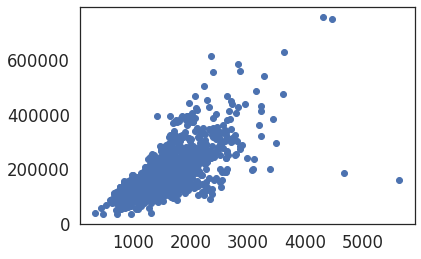

In [23]:
plt.scatter(x=dataset['GrLivArea'], y=dataset['SalePrice'])
plt.show()

In [24]:
cond1 = dataset['GrLivArea'] > 4000
cond2 = dataset['SalePrice'] < 500000
outlier_index = dataset[cond1 & cond2].index
outlier_index   # train 영역

Int64Index([523, 1298], dtype='int64')

In [25]:
dataset.drop(outlier_index, axis=0, inplace=True)

In [26]:
train_len -= 2

In [27]:
train = dataset[:train_len-2]
test = dataset[train_len-2:]

In [28]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print('dataset.shape :', dataset.shape)

train.shape : (1456, 76)
test.shape : (1461, 76)
dataset.shape : (2917, 76)


## 2-3) Correlation

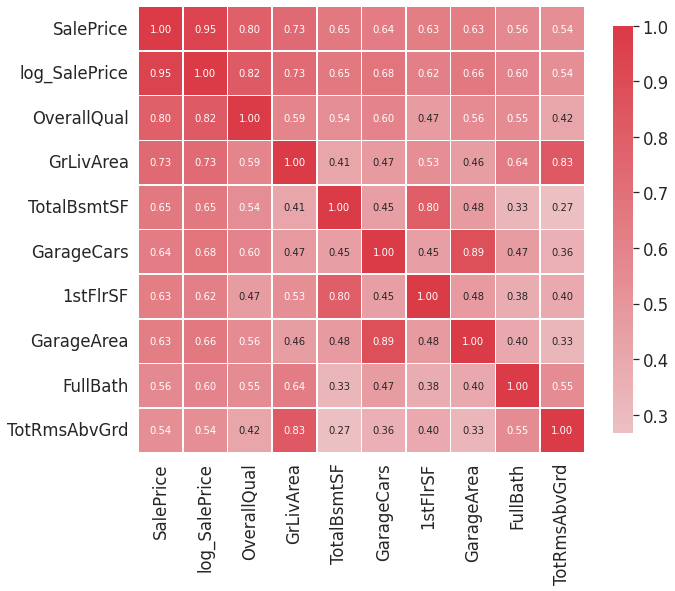

In [29]:
# 상관계수가 높은 것만
corr_train = train.corr()
num=10
col = corr_train.nlargest(num, 'SalePrice')['SalePrice'].index
coeff = np.corrcoef(train[col].values.T)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(coeff, xticklabels = col.values, yticklabels = col.values,
            cmap=cmap, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
plt.show()

# 3) Feature Engineering

## 3-2) Skew

In [30]:
features_index = dataset.dtypes[dataset.dtypes != 'object'].index
features_index

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'log_SalePrice'],
      dtype='object')

In [31]:
from scipy.stats import skew
skew_features = dataset[features_index].apply(lambda x : skew(x))
skew_features

MSSubClass        1.375131
LotFrontage       1.102764
LotArea          13.109495
OverallQual       0.189591
OverallCond       0.569314
YearBuilt        -0.599194
YearRemodAdd     -0.450134
MasVnrArea        2.621719
BsmtFinSF1        0.980645
BsmtFinSF2        4.144503
BsmtUnfSF         0.919688
TotalBsmtSF       0.671751
1stFlrSF          1.257286
2ndFlrSF          0.861556
LowQualFinSF     12.084539
GrLivArea         1.068750
BsmtFullBath      0.622415
BsmtHalfBath      3.929996
FullBath          0.165514
HalfBath          0.696666
BedroomAbvGr      0.326568
KitchenAbvGr      4.300550
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
GarageYrBlt      -3.904632
GarageCars       -0.219297
GarageArea        0.216857
WoodDeckSF        1.844792
OpenPorchSF       2.529358
EnclosedPorch     4.002344
3SsnPorch        11.372080
ScreenPorch       3.945101
PoolArea         17.688664
MiscVal          21.939672
MoSold            0.197345
YrSold            0.131996
SalePrice              NaN
l

In [32]:
skew_features_top = skew_features[skew_features > 1]
skew_features_top.sort_values(ascending=False)

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
MSSubClass        1.375131
1stFlrSF          1.257286
LotFrontage       1.102764
GrLivArea         1.068750
dtype: float64

In [33]:
'SalePrice' in skew_features_top, 'log_SalePrice' in skew_features_top

(False, False)

In [34]:
dataset[skew_features_top.index] = np.log1p(dataset[skew_features_top.index])

## 3-1) Encoding (categorical)

- Utilities, MasVnrType, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, GarageCond <br>
결측치 O

In [35]:
# get_dummies() => 문자열 피처의 Null 값을 'None'으로
dataset = pd.get_dummies(dataset)

# 4) Modeling

## 4-0) Data split

In [36]:
dataset.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,log_SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,...,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,706.0,0.0,150.0,856.0,6.753438,854,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,8,0,2003.0,2.0,548.0,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,208500.0,12.247699,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,978.0,0.0,284.0,1262.0,7.141245,0,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,6,1,1976.0,2.0,460.0,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,181500.0,12.109016,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,486.0,0.0,434.0,920.0,6.825460,866,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,6,1,2001.0,2.0,608.0,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,223500.0,12.317171,0,0,0,1,0,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,216.0,0.0,540.0,756.0,6.869014,756,0.0,7.448916,1.0,0.000000,1,0,3,0.693147,7,1,1998.0,3.0,642.0,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,140000.0,11.849405,0,0,0,1,0,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,655.0,0.0,490.0,1145.0,7.044033,1053,0.0,7.695758,1.0,0.000000,2,1,4,0.693147,9,1,2000.0,3.0,836.0,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,250000.0,12.429220,0,0,0,1,0,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [37]:
train = dataset[:train_len]
test = dataset[train_len:]
train.drop(['SalePrice'], axis=1, inplace=True)
test.drop(['SalePrice','log_SalePrice'], axis=1, inplace=True)

In [38]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,log_SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,...,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,706.0,0.0,150.0,856.0,6.753438,854,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,8,0,2003.0,2.0,548.0,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,12.247699,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,978.0,0.0,284.0,1262.0,7.141245,0,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,6,1,1976.0,2.0,460.0,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,12.109016,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,486.0,0.0,434.0,920.0,6.825460,866,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,6,1,2001.0,2.0,608.0,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,12.317171,0,0,0,1,0,0,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,216.0,0.0,540.0,756.0,6.869014,756,0.0,7.448916,1.0,0.000000,1,0,3,0.693147,7,1,1998.0,3.0,642.0,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,11.849405,0,0,0,1,0,0,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,655.0,0.0,490.0,1145.0,7.044033,1053,0.0,7.695758,1.0,0.000000,2,1,4,0.693147,9,1,2000.0,3.0,836.0,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,12.429220,0,0,0,1,0,0,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [39]:
X, y = train.drop('log_SalePrice', axis=1), train['log_SalePrice']

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

## 4-1) Basic Algorithms

### function

In [41]:
def rmse(y, pred) :
  return np.sqrt(mean_squared_error(y, pred))

In [42]:
def get_model_predict(model, X_train, X_test, y_train, y_test) :
  print('<<', model.__class__.__name__, '>>')

  model.fit(X_train.values, y_train.values)
  pred = model.predict(X_test.values)

  print(rmse(y_test.values, pred))
  RMSE.append(rmse(y_test.values, pred))

  # 트리 모델 X
  try: 
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    coef_concat = pd.concat([coef_high, coef_low], axis=0)
    plt.figure(figsize=(8,8))
    sns.barplot(x=coef_concat.values, y=coef_concat.index)
    plt.show()
  except :
    pass

### CV

<< LinearRegression >>
[0.11496904 0.12481615 0.13847979 0.11021853 0.11621417]
0.12093953599359823


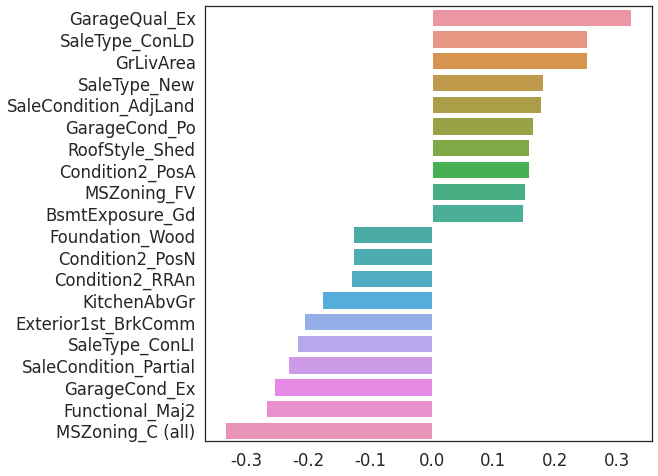

<< Ridge >>
[0.10781536 0.11914094 0.12748194 0.10522078 0.1133879 ]
0.11460938287886072


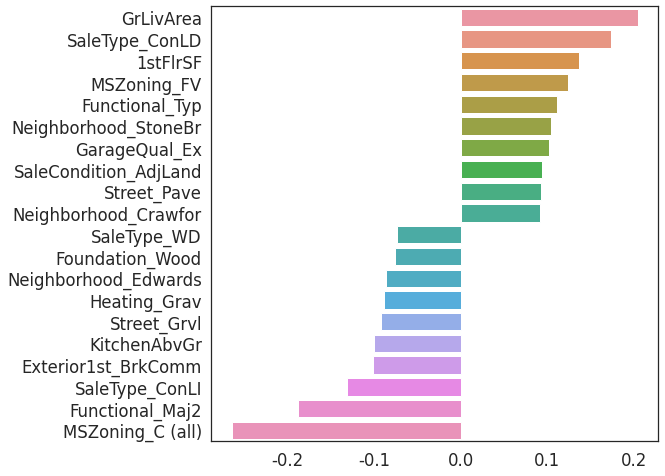

<< Lasso >>
[0.18156342 0.18539391 0.18759314 0.19513556 0.18270159]
0.18647752365337067


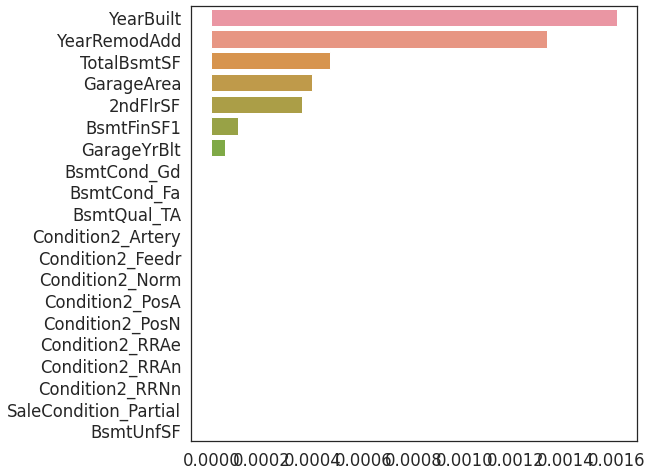

<< RandomForestRegressor >>
[0.13605246 0.13992416 0.14403543 0.12917948 0.13861118]
0.13756053951354122


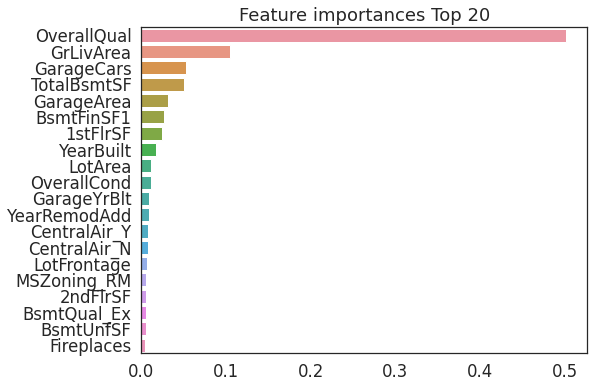

<< GradientBoostingRegressor >>
[0.11062043 0.1275537  0.1261471  0.1069031  0.11916191]
0.11807724895586746


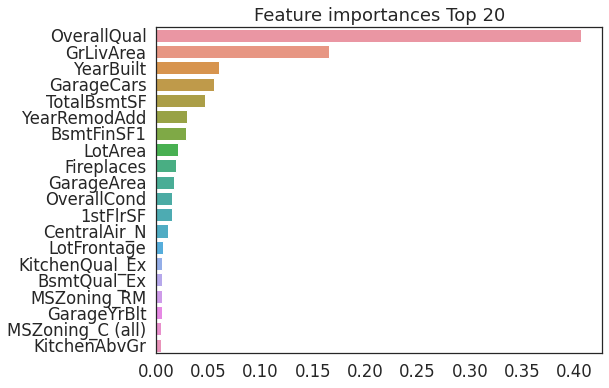

<< XGBRegressor >>
[05:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.10607297 0.12483358 0.127484   0.10749048 0.12127537]
0.11743128064920416


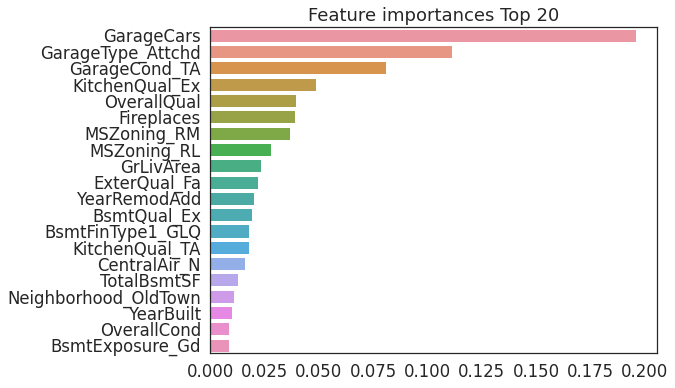

<< LGBMRegressor >>
[0.12247827 0.13504484 0.13384184 0.11866175 0.12510843]
0.12702702604348198


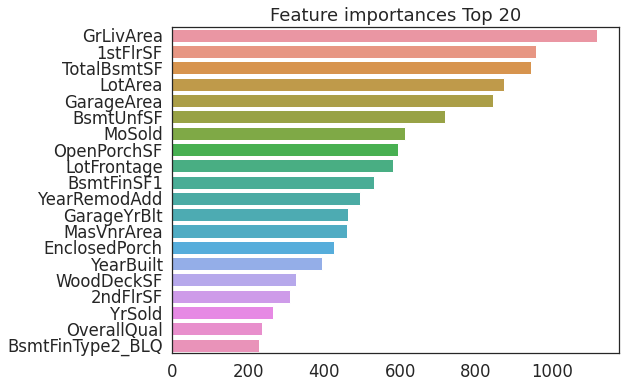

,RMSE_cv
LinearRegression,0.120940
Ridge,0.114609
Lasso,0.186478
RandomForestRegressor,0.137561
GradientBoostingRegressor,0.118077
XGBRegressor,0.117431
LGBMRegressor,0.127027


In [43]:
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

models = [lr_reg, ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]
models_name = [model.__class__.__name__ for model in models]

RMSE_cv = []

for model in models :

  print('<<', model.__class__.__name__, '>>')

  model.fit(X_train.values, y_train.values)
  pred = model.predict(X_val.values)

  rmse_lst = np.sqrt(-cross_val_score(model, train.drop('log_SalePrice', axis=1), train['log_SalePrice'], scoring='neg_mean_squared_error', cv=5))
  print(rmse_lst)
  print(np.mean(rmse_lst))
  RMSE_cv.append(np.mean(rmse_lst))

  # 트리 모델 X
  try: 
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    coef_concat = pd.concat([coef_high, coef_low], axis=0)
    plt.figure(figsize=(8,8))
    sns.barplot(x=coef_concat.values, y=coef_concat.index)
    plt.show()

  except :
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

    plt.figure(figsize=(8,6))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20, y=ftr_top20.index)
    plt.show()

  print('='*100)

models_cv_dataframe = pd.DataFrame({'RMSE_cv':RMSE_cv}, index=models_name)
models_cv_dataframe

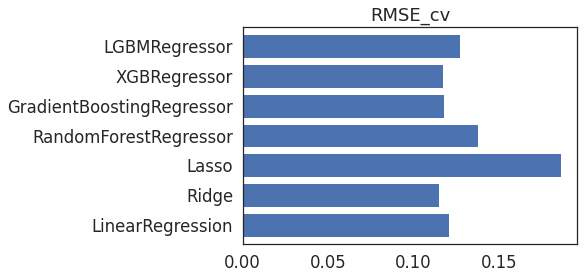

In [45]:
for i in models_cv_dataframe.columns :
  models_cv_dataframe[i].plot.barh(width=0.8)
  plt.title(i)
  plt.show()

## 4-2) Hyper-Parameters Tuning

### Ridge

In [46]:
model = Ridge()

params = {'max_iter':[3000],
          'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}

gd=GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
gd.fit(X, y)
rmse = np.sqrt(-1*gd.best_score_)

print('rmse :', np.round(rmse, 4))
print(gd.best_estimator_)

rmse : 0.1112
Ridge(alpha=10, max_iter=3000)


### Lasso

In [47]:
model = Lasso()

params = {'max_iter':[3000],
          'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}

gd=GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
gd.fit(X, y)
rmse = np.sqrt(-1*gd.best_score_)

print('rmse :', np.round(rmse, 4))
print(gd.best_estimator_)

rmse : 0.1787
Lasso(alpha=0.1, max_iter=3000)


### GradientBoostingRegressor

In [48]:
model = GradientBoostingRegressor()

params = {'max_depth': [3,4,5,7],
          'n_estimators': [100,200,300]}

gd=GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
gd.fit(X, y)
rmse = np.sqrt(-1*gd.best_score_)

model = gd.best_estimator_

print('rmse :', np.round(rmse, 4))
print(gd.best_estimator_)

rmse : 0.1185
GradientBoostingRegressor(n_estimators=300)


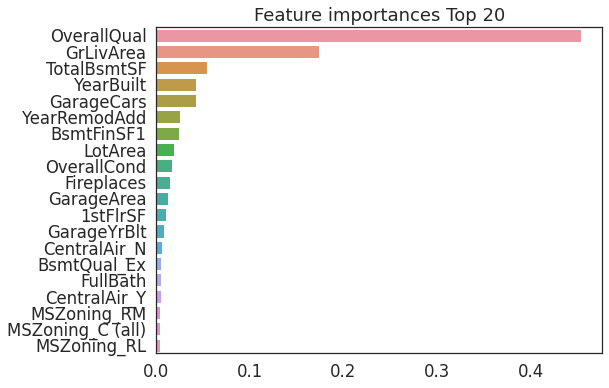

In [49]:
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### XGBoost

In [50]:
model = XGBRegressor()

params = {'max_depth': [3,4,5,7],
          'n_estimators': [100,200,300]}

gd=GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
gd.fit(X, y)
rmse = np.sqrt(-1*gd.best_score_)

model = gd.best_estimator_

print('rmse :', np.round(rmse, 4))
print(gd.best_estimator_)

[05:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

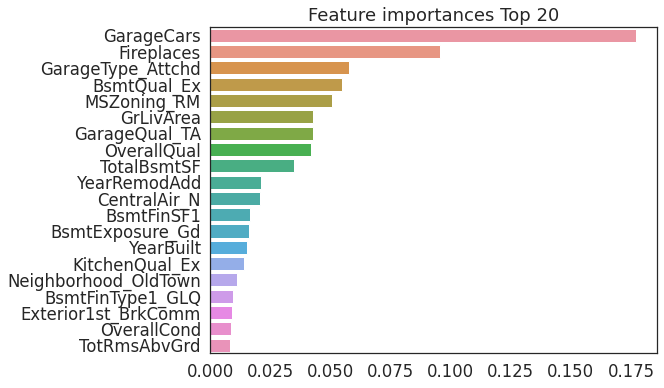

In [51]:
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### LightGBM

In [52]:
model = LGBMRegressor(random_state=0)

params = {'max_depth': [3,4,5,7],
          'n_estimators': [100,200,300]}

gd=GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
gd.fit(X, y)
rmse = np.sqrt(-1*gd.best_score_)

model = gd.best_estimator_

print('rmse :', np.round(rmse, 4))
print(gd.best_estimator_)

rmse : 0.1213
LGBMRegressor(max_depth=3, n_estimators=300, random_state=0)


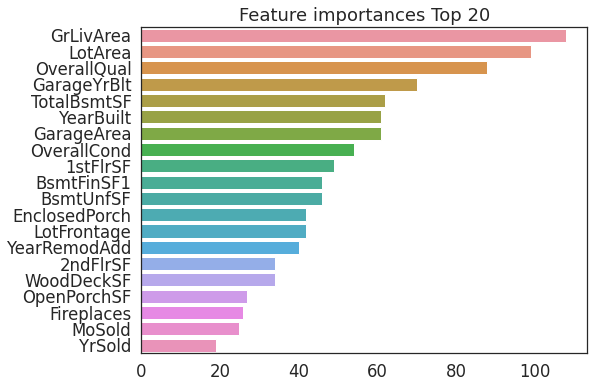

In [55]:
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## 4-3) Voting
- Ensemble : Voting, Bagging(model), Boosting(model)

In [64]:
model = VotingRegressor(estimators=[('Ridge',Ridge(alpha=10, max_iter=3000)),
                                   ('Lasso',Lasso(alpha=0.1, max_iter=3000)),
                                   ('gbd',GradientBoostingRegressor(n_estimators=300)),
                                   ('xgb',XGBRegressor(n_estimators=300)),
                                   ('lgbm',LGBMRegressor(max_depth=3, n_estimators=300, random_state=0))],
                         weights=[3,1.3,1,1,1]).fit(X_train, y_train)

[05:23:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
pred = model.predict(X_val)

rmse_lst = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
print(rmse_lst)
print(np.mean(rmse_lst))

[05:23:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.10781557 0.11668606 0.12058596 0.10552854 0.1107884 ]
0.11228090650001041


## 4-4) Stacking

In [73]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [74]:
ridge = Ridge(alpha=10, max_iter=3000)
lasso = Lasso(alpha=0.1, max_iter=3000)
gdb = GradientBoostingRegressor(n_estimators=300)
xgb = XGBRegressor(n_estimators=300)
lgbm = LGBMRegressor(max_depth=3, n_estimators=300, random_state=0)

In [75]:
X_train_n = X_train.values
y_train_n = y_train.values
X_val_n = X_val.values

In [76]:
ridge_train, ridge_val = get_stacking_base_datasets(ridge, X_train_n, y_train_n, X_val_n, 5)
lasso_train, lasso_val = get_stacking_base_datasets(lasso, X_train_n, y_train_n, X_val_n, 5)
gdb_train, gdb_val = get_stacking_base_datasets(gdb, X_train_n, y_train_n, X_val_n, 5)
xgb_train, xgb_val = get_stacking_base_datasets(xgb, X_train_n, y_train_n, X_val_n, 5)
lgbm_train, lgbm_val = get_stacking_base_datasets(lgbm, X_train_n, y_train_n, X_val_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
GradientBoostingRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[06:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[06:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[06:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[06:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[06:27:45] WARNING: /workspace/src/objective/regression_o

In [77]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, gdb_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_val = np.concatenate((ridge_val, lasso_val, gdb_val, xgb_val, lgbm_val), axis=1)

In [79]:
meta_model_ridge = Ridge(alpha=0.0005)
meta_model_ridge.fit(Stack_final_X_train, y_train)

Ridge(alpha=0.0005)

In [80]:
final = meta_model_ridge.predict(Stack_final_X_val)
mse = mean_squared_error(y_val, final)
rmse = np.sqrt(mse)
rmse

0.10630265710017338

# 5) Prediction on Test Set & Submission 

## 5-1) Prediction

In [85]:
# model = Ridge(alpha=10, max_iter=3000)
meta_model_ridge.fit(X,y)
pred = meta_model_ridge.predict(test)

## 5-2) Submission

In [66]:
Idtest

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [90]:
sub_pred = pd.Series(pred, name="SalePrice")
sub_pred = np.expm1(sub_pred)
sub_pred

0       122558.720732
1       157350.934185
2       189650.799291
3       199656.726448
4       197783.369359
            ...      
1454     86364.695901
1455     81334.287065
1456    172235.591826
1457    121208.213915
1458    218853.128015
Name: SalePrice, Length: 1459, dtype: float64

In [92]:
results = pd.concat([Idtest,sub_pred], axis=1)

results.to_csv("house_4.csv", index=False)

0.13778